In [32]:
import numpy as np; np.set_printoptions(precision=3)
import pandas as pd; pd.set_option('display.precision',3)
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
from sklearn.model_selection import train_test_split
real=pd.read_csv("real.csv",index_col=0)
real.head()

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
No,,,,,,,
1,2012.917,32.0,84.879,10,24.983,121.540,37.9
2,2012.917,19.5,306.595,9,24.980,121.540,42.2
3,2013.583,13.3,561.985,5,24.987,121.544,47.3
4,2013.500,13.3,561.985,5,24.987,121.544,54.8
5,2012.833,5.0,390.568,5,24.979,121.542,43.1


In [25]:
real.columns=['date','house_age','dist_mrt','con_store','lat','long','price']

In [26]:
real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414 entries, 1 to 414
Data columns (total 7 columns):
date         414 non-null float64
house_age    414 non-null float64
dist_mrt     414 non-null float64
con_store    414 non-null int64
lat          414 non-null float64
long         414 non-null float64
price        414 non-null float64
dtypes: float64(6), int64(1)
memory usage: 25.9 KB


In [28]:
real.describe()

,date,house_age,dist_mrt,con_store,lat,long,price
count,414.000,414.000,414.000,414.000,414.000,414.000,414.000
mean,2013.149,17.713,1083.886,4.094,24.969,121.533,37.980
std,0.282,11.392,1262.110,2.946,0.012,0.015,13.606
min,2012.667,0.000,23.383,0.000,24.932,121.474,7.600
25%,2012.917,9.025,289.325,1.000,24.963,121.528,27.700
50%,2013.167,16.100,492.231,4.000,24.971,121.539,38.450
75%,2013.417,28.150,1454.279,6.000,24.977,121.543,46.600
max,2013.583,43.800,6488.021,10.000,25.015,121.566,117.500


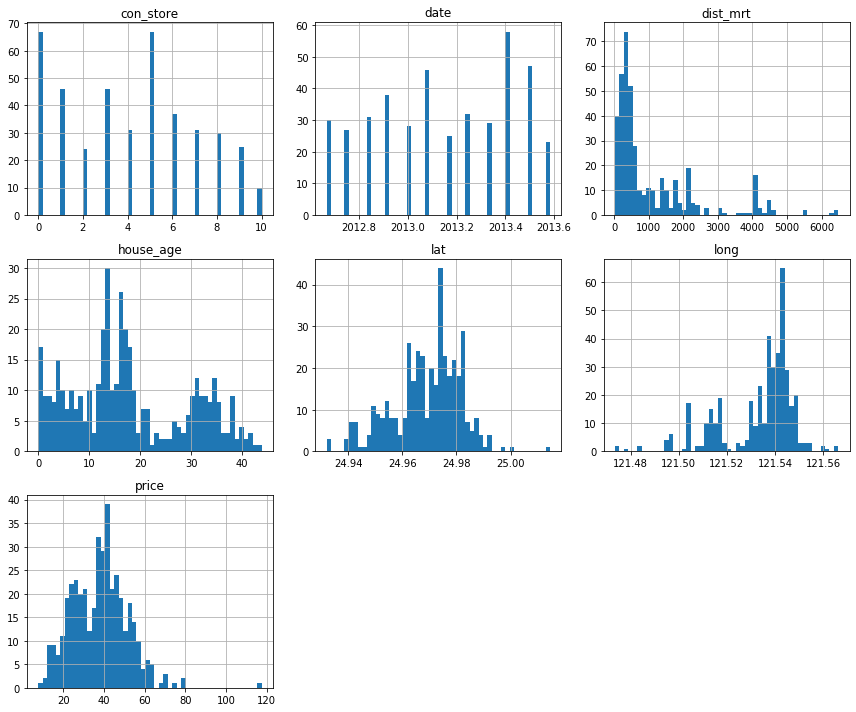

In [29]:
real.hist(bins=50, figsize=(12,10))
plt.tight_layout()

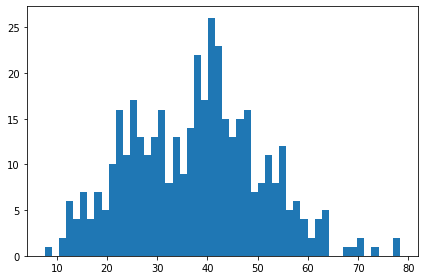

In [30]:
real = real[real.price < 80] #거리 80이상은 제외하였다
plt.hist(real.price, bins=50)
plt.tight_layout()

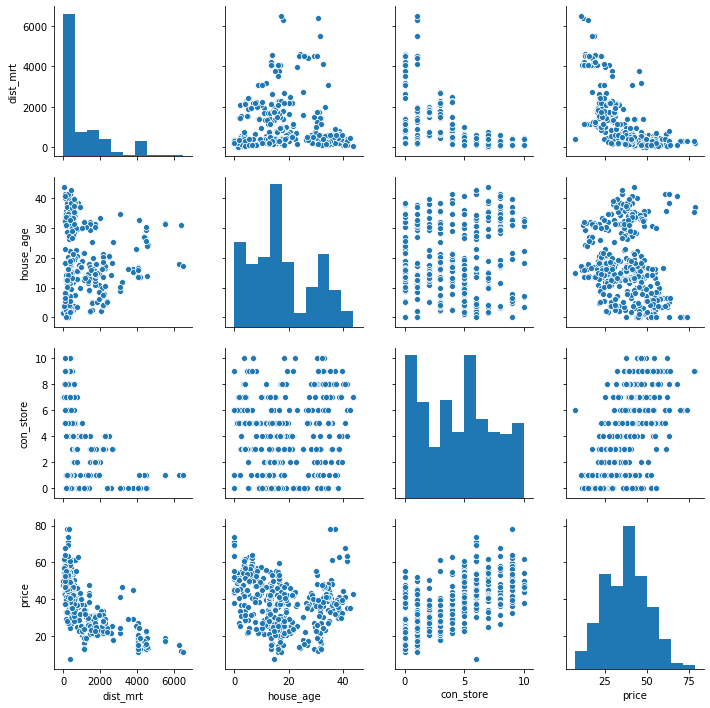

In [35]:
sns.pairplot(real[['dist_mrt', 'house_age', 'con_store', 'price']])

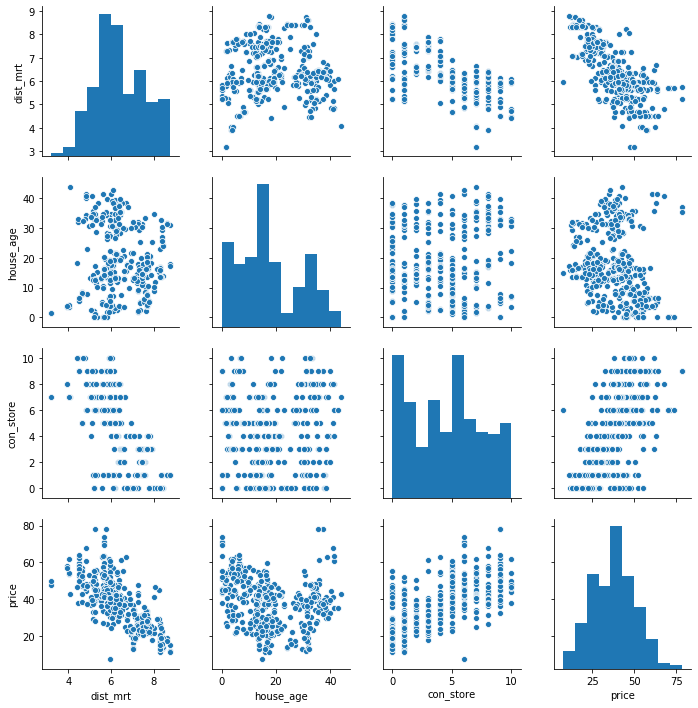

In [36]:
real2 = real.copy()
real2['dist_mrt'] = np.log(1+real.dist_mrt) #bell shape로 만들고자 함
sns.pairplot(real2[['dist_mrt', 'house_age','con_store','price']])

In [37]:
data=real2[['dist_mrt','house_age','price']]

In [39]:
X=real2[['dist_mrt','house_age']]
Y=real2['price']

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state=77)

In [41]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)

def Scl_train(sclr, df):
    colnames = df.columns
    df = sclr.transform(df)
    df = pd.DataFrame(df)
    df.set_axis(colnames, axis=1, inplace=True)
    return df

In [42]:
X_train_sc = Scl_train(scaler, X_train)
X_train_sc.describe()

,dist_mrt,house_age
count,2.890e+02,2.890e+02
mean,8.836e-17,2.299e-16
std,1.002e+00,1.002e+00
min,-2.896e+00,-1.505e+00
25%,-5.921e-01,-8.152e-01
50%,-1.212e-01,-1.254e-01
75%,8.448e-01,8.475e-01
max,2.297e+00,2.369e+00


In [44]:
X_test_sc = Scl_train(scaler, X_test)
X_test_sc.describe()

,dist_mrt,house_age
count,124.000,124.000
mean,0.276,0.210
std,1.101,1.013
min,-2.896,-1.505
25%,-0.423,-0.417
50%,0.109,-0.046
75%,1.187,1.274
max,2.146,2.156


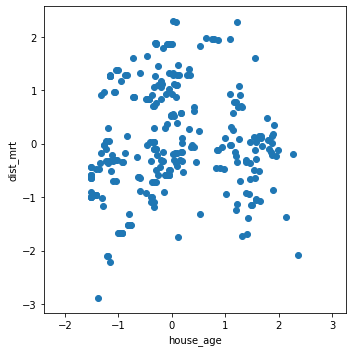

In [45]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(X_train_sc.house_age, X_train_sc.dist_mrt)
ax.set_xlabel('house_age')
ax.set_ylabel('dist_mrt')
ax.axis('equal')
fig.tight_layout()

In [48]:
import plotly.express as px
fig = px.scatter_3d(x=X_train_sc.dist_mrt, y=X_train_sc.house_age, z=Y_train)
fig.update_traces(marker=dict(size=4,
                              line=dict(width=0.1,
                                        color='red')))
fig.show()

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import plotly.express as px

def Poly_Reg(X_train, Y_train, X_test, Y_test, m):
    # Feature Extraction
    poly = PolynomialFeatures(degree=m)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)

    # LR Fitting
    lin = LinearRegression(fit_intercept=False)
    lin.fit(X_train_poly, Y_train)
    Y_train_pred = lin.predict(X_train_poly)
    Y_test_pred = lin.predict(X_test_poly)

    # Compue MSE
    train_MSE = np.sqrt(np.linalg.norm(Y_train - Y_train_pred)**2/Y_train.shape[0])
    test_MSE = np.sqrt(np.linalg.norm(Y_test - Y_test_pred)**2/Y_test.shape[0])

    # Residual
    Resid = Y_train - Y_train_pred

    return {'coef': lin.coef_, 'train_MSE': train_MSE, 'test_MSE': test_MSE, 'Resid': Resid}

PRmodel = Poly_Reg(X_train_sc,Y_train,X_test_sc,Y_test,2)
PRmodel
fig = px.scatter_3d(x=X_train_sc.dist_mrt, y=X_train_sc.house_age, z=PRmodel['Resid'])
fig.update_traces(marker=dict(size=4,
                              line=dict(width=0.1,
                                        color='DarkSlateGrey')))


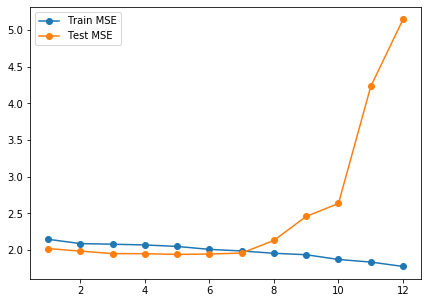

In [53]:
output = pd.DataFrame(columns=['d','Train MSE','Test MSE'])
for i in np.arange(12):
    m = i+1
    Reg = Poly_Reg(X_train_sc, Y_train, X_test_sc, Y_test, m)
    output.loc[i] = [m, Reg['train_MSE'], Reg['test_MSE']]


fig, ax = plt.subplots(figsize=(7,5))
ax.plot(output['d'], np.log(output['Train MSE']), 'o-', label='Train MSE')
ax.plot(output['d'], np.log(output['Test MSE']), 'o-', label='Test MSE')

ax.legend()

In [74]:
poly = PolynomialFeatures(degree=2)
phi_train = poly.fit_transform(X_train_sc)
phi_test = poly.fit_transform(X_test_sc)
print(Phi_train.shape)
print(Phi_test.shape)

(289, 6)
(124, 6)


In [78]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
alphas=np.logspace(-6, 6, 500)
def Ridge_Reg(Phi_train, Y_train, Phi_test, Y_test, alphas, fig=False):
    
    ## How to Ridge?##
    #1. Call Ridge function as an object
    reg = Ridge()
    
    coefs = []
    train_MSE = []
    test_MSE = []
    
    for a in alphas:
        #2. Choose your lambda (Regularization coefficient)
        reg.set_params(alpha=a)
        
        #3. Fit your model
        reg.fit(Phi_train, Y_train)
        
        #4 view result with reg.coef_, reg.predict, ...
        coefs.append(reg.coef_)
    
        train_pred = reg.predict(Phi_train)
        train_MSE.append(mean_squared_error(Y_train, train_pred))
    
        test_pred = reg.predict(Phi_test)
        test_MSE.append(mean_squared_error(Y_test, test_pred))
   
    ## just for plotting purpose.. trivial ##
    #print(np.array(coefs).shape)
    
    if fig==True:
        fig = plt.figure(figsize=(14,6))

        ax1 = fig.add_subplot(121)
        labels = ['X%d'%i for i in range(Phi_train.shape[1])]
        for i in range(Phi_train.shape[1]):
            ax1.plot(alphas, np.array(coefs)[:,i], label=labels[i])
        ax1.set_xscale('log')
        ax1.axvline(x=alphas[np.argmin(test_MSE)], linestyle='--', color='grey')
        ax1.legend()

        ax2 = fig.add_subplot(122)
        ax2.plot(alphas, train_MSE, label='Train MSE')
        ax2.plot(alphas, test_MSE, label='Test MSE')
        ax2.set_xscale('log')
        ax2.axvline(x=alphas[np.argmin(test_MSE)], linestyle='--', color='grey')
        alpha = np.around(alphas[np.argmin(test_MSE)],3)
        ax2.text(alphas[np.argmin(test_MSE)], np.amin(test_MSE), 'alpha={0}'.format(alpha), size=15)
        ax2.legend()

        print("Weight:" ,coefs[np.argmin(test_MSE)])
        
    return {'coefs': coefs, 'train_MSE': train_MSE, 'test_MSE': test_MSE}

Weight: [ 0.    -8.02  -3.435 -1.817  0.479  1.942]


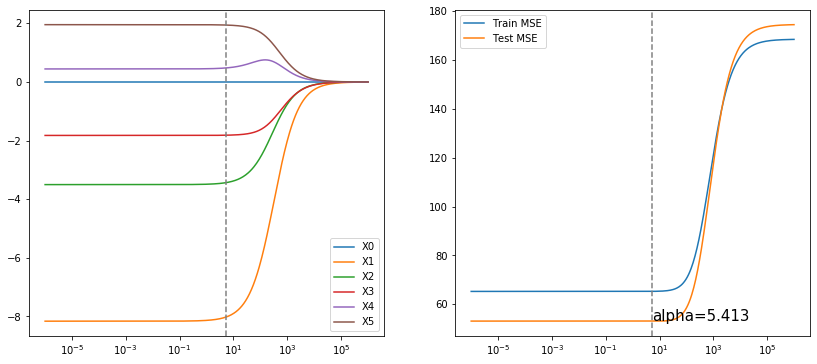

In [79]:
Ridge_output = Ridge_Reg(Phi_train, Y_train, Phi_test, Y_test, alphas, fig=True)

In [80]:
from sklearn.linear_model import Lasso
alphas=np.logspace(-6, 6, 500)

In [81]:
def Lasso_Reg(Phi_train, Y_train, Phi_test, Y_test, alphas, fig=False):
    
    ## How to Lasso?##
    #1. Call Lasso function as an object
    reg = Lasso()
    
    coefs = []
    train_MSE = []
    test_MSE = []
    
    for a in alphas:
        #2. Choose your lambda (Regularization coefficient)
        reg.set_params(alpha=a)
        
        #3. Fit your model
        reg.fit(Phi_train, Y_train)
        
        #4 view result with reg.coef_, reg.predict, ...
        coefs.append(reg.coef_)
    
        train_pred = reg.predict(Phi_train)
        train_MSE.append(mean_squared_error(Y_train, train_pred))
    
        test_pred = reg.predict(Phi_test)
        test_MSE.append(mean_squared_error(Y_test, test_pred))
    
    ## just for plotting purpose.. trivial ##
    #print(np.array(coefs).shape)
    if fig==True:
        fig = plt.figure(figsize=(14,6))

        ax1 = fig.add_subplot(121)
        labels = ['X%d'%i for i in range(Phi_train.shape[1])]
        for i in range(Phi_train.shape[1]):
            ax1.plot(alphas, np.array(coefs)[:,i], label=labels[i])
        ax1.set_xscale('log')
        ax1.axvline(x=alphas[np.argmin(test_MSE)], linestyle='--', color='grey')
        ax1.legend()

        ax2 = fig.add_subplot(122)
        ax2.plot(alphas, train_MSE, label='Train MSE')
        ax2.plot(alphas, test_MSE, label='Test MSE')
        ax2.set_xscale('log')
        ax2.axvline(x=alphas[np.argmin(test_MSE)], linestyle='--', color='grey')
        alpha = np.around(alphas[np.argmin(test_MSE)],3)
        ax2.text(alphas[np.argmin(test_MSE)], np.amin(test_MSE), 'alpha={0}'.format(alpha), size=15)
        ax2.legend()

        print("Weight:" ,coefs[np.argmin(test_MSE)])
        
    return {'coefs': coefs, 'train_MSE': train_MSE, 'test_MSE': test_MSE}

Weight: [ 0.000e+00 -8.082e+00 -2.944e+00 -1.477e+00  8.956e-04  1.405e+00]


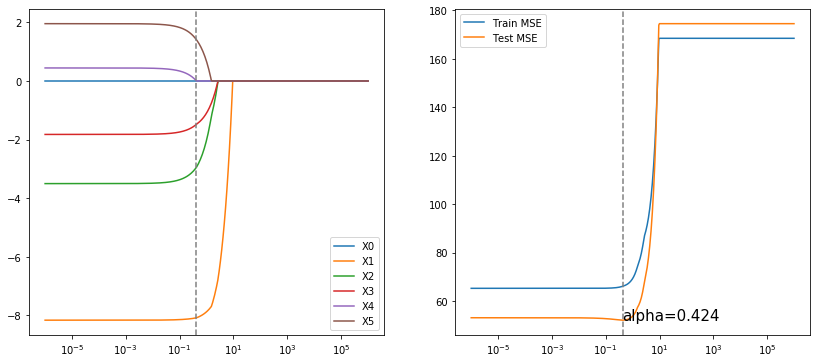

In [82]:
Lasso_output = Lasso_Reg(Phi_train, Y_train, Phi_test, Y_test, alphas, fig=True)

In [83]:
from sklearn.model_selection import KFold

kcv = KFold(n_splits=5, shuffle=True)

kcvMSE_Ridge = np.zeros((kcv.get_n_splits(), alphas.size))
kcvMSE_Lasso = np.zeros((kcv.get_n_splits(), alphas.size))

i = 0
for train_index, test_index in kcv.split(Phi_train, Y_train):
    print("TRAIN:", train_index, "TEST:", test_index)
    CV_Phi_train, CV_Phi_test = Phi_train[train_index,:], Phi_train[test_index,:]
    CV_Y_train, CV_Y_test = Y_train.iloc[train_index], Y_train.iloc[test_index]
    
    Ridge_output = Ridge_Reg(CV_Phi_train, CV_Y_train, CV_Phi_test, CV_Y_test, alphas, fig=False)
    kcvMSE_Ridge[i, :] = Ridge_output['test_MSE']
    
    Lasso_output = Lasso_Reg(CV_Phi_train, CV_Y_train, CV_Phi_test, CV_Y_test, alphas, fig=False)
    kcvMSE_Lasso[i, :] = Lasso_output['test_MSE']
    i += 1

TRAIN: [  0   1   3   4   5   6   7   8  11  13  15  16  17  18  19  20  21  22
  23  24  26  28  29  30  31  32  33  34  35  36  37  38  39  40  41  43
  44  45  47  48  49  50  51  52  53  55  57  58  59  60  61  62  65  67
  69  70  71  72  73  74  75  77  78  79  81  82  83  85  86  87  91  92
  93  94  95  96  97  98  99 100 103 104 105 107 108 109 110 111 112 113
 114 115 116 118 119 120 121 124 127 128 129 131 132 133 134 136 137 138
 139 140 141 142 143 144 145 146 147 148 150 151 152 153 154 155 156 157
 159 160 161 162 163 167 168 169 170 172 173 176 177 179 180 181 183 184
 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 201 202 203
 205 206 207 208 210 211 212 213 214 215 216 217 218 219 220 221 223 224
 225 226 229 230 231 232 233 235 236 237 238 239 240 241 243 246 247 249
 250 251 252 254 256 257 258 259 260 262 263 264 265 266 267 268 270 271
 272 273 274 275 276 277 279 280 281 282 283 284 286 287 288] TEST: [  2   9  10  12  14  25  27  42  46  54  56  63 

Weight: [ 0.    -8.038 -3.174 -1.906  0.455  1.822]


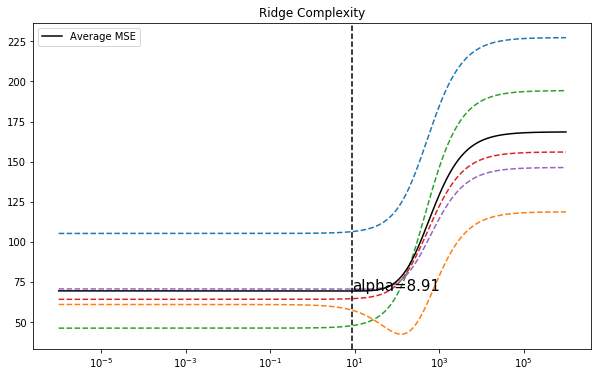

In [84]:
fig, ax= plt.subplots(figsize=(10,6))
meanMSE = np.apply_along_axis(np.mean, 1, kcvMSE_Ridge.T)
ax.plot(alphas, kcvMSE_Ridge.T, linestyle='--')
ax.plot(alphas, meanMSE, color='black', label='Average MSE')
ax.set_xscale('log')
ax.axvline(x=alphas[np.argmin(meanMSE)], linestyle='--', color='black')
alpha = np.around(alphas[np.argmin(meanMSE)],3)
ax.text(alphas[np.argmin(meanMSE)], np.amin(meanMSE), 'alpha={0}'.format(alpha), size=15)
ax.set_title('Ridge Complexity')
ax.legend()

coefs = Ridge_output['coefs']
print("Weight:" ,coefs[np.argmin(meanMSE)])
Ridge_alphas = [alphas[np.argmin(meanMSE)]]

Weight: [ 0.    -8.304 -3.143 -1.829  0.286  1.68 ]


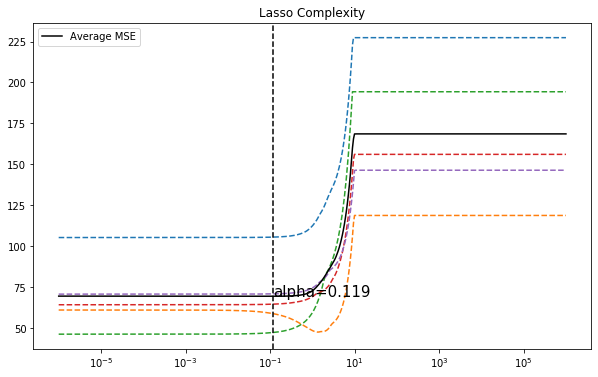

In [85]:
fig, ax= plt.subplots(figsize=(10,6))
meanMSE = np.apply_along_axis(np.mean, 1, kcvMSE_Lasso.T)
ax.plot(alphas, kcvMSE_Lasso.T, linestyle='--')
ax.plot(alphas, meanMSE, color='black', label='Average MSE')
ax.set_xscale('log')
ax.axvline(x=alphas[np.argmin(meanMSE)], linestyle='--', color='black')
alpha = np.around(alphas[np.argmin(meanMSE)],3)
ax.text(alphas[np.argmin(meanMSE)], np.amin(meanMSE), 'alpha={0}'.format(alpha), size=15)
ax.set_title('Lasso Complexity')
ax.legend()

coefs = Lasso_output['coefs']
print("Weight:" ,coefs[np.argmin(meanMSE)])
Lasso_alphas = [alphas[np.argmin(meanMSE)]]

In [89]:
PRmodel['coef']
PRmodel['test_MSE']


7.288122782574814

In [99]:
Ridge_output = Ridge_Reg(phi_train, Y_train, phi_test, Y_test, Ridge_alphas)
print(Ridge_output['test_MSE'])
Ridge_alphas
Ridge_output['coefs']


[50.5062192014636]


[array([ 0.   , -8.46 , -4.075, -1.858,  0.76 ,  1.727,  0.274,  0.138,
        -0.179,  0.322])]

In [97]:
Lasso_output = Lasso_Reg(phi_train, Y_train, phi_test, Y_test, Lasso_alphas)
Lasso_output['test_MSE']

[50.120497418303785]

위의 결과를 보면 lasso의 mse가 ridge보다 약간 낮음을 확인할 수 있다.